```
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

## Demographic Bias Analysis

This notebook is to produce results from image cropping. We conduct the analysis on the Wikipedia data.

Results are recorded in .txt files.

In [49]:
import math
import os
import random
import shlex
import subprocess
import sys
import time
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.patches import Rectangle
from PIL import Image

## Add seed for reproducibility
random.seed(42)
np.random.seed(42)

In [40]:
# ! rm -rf attached

In [50]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

True

# Collecting and Cleaning Data

In [51]:
def get_filepaths(directory):
    file_paths = []  # List which will store all of the full filepaths.
    file_paths = [str(p) for p in Path(directory).glob("*")]
    return file_paths

## Read and process Wiki image data

In [52]:
# [Instruction]: out the folder directory which contains all the images here
IMG_DIR_PATH = data_dir / "./images"
print("Directory exists:", Path(IMG_DIR_PATH).exists())

# get the list of all files path
full_file_paths = get_filepaths(IMG_DIR_PATH)

Directory exists: True


In [53]:
IMAGE_MAP_PATH = data_dir / "./dataset.tsv"
print("File exists:", Path(IMAGE_MAP_PATH).exists())
IMAGE_DATA_PATH = data_dir / "./dataset.json"
print("File exists:", Path(IMAGE_DATA_PATH).exists())

File exists: True
File exists: True


In [54]:
def read_wiki_img_data():
    df = pd.read_csv(IMAGE_MAP_PATH, sep="\t")
    df["path"] = df.local_path.apply(lambda x: IMG_DIR_PATH / x)

    print(
        "Reading finished. Cleaning .pdf mistakes:",
        sum(df.local_path.apply(lambda x: x[-3:]) == "pdf"),
        "entities filtered.",
    )
    df = df[
        df.local_path.apply(lambda x: x[-3:]) != "pdf"
    ]  # clean out one wrong example, if exists
    return df


wiki_pandas = read_wiki_img_data()
wiki_pandas

Reading finished. Cleaning .pdf mistakes: 0 entities filtered.


,human,image,sex_or_gender,ethnic_group,occupation,loc_aid,url,local_path,file_exists,path
0,Q335552,Jack_Dorsey_2014.jpg,Q6581097,Q1075293,Q131524,n2011042258,http://commons.wikimedia.org/wiki/Special:File...,Q335552.jpg,False,../data/images/Q335552.jpg


In [55]:
gender_map_dict = {"Q6581072": "female", "Q6581097": "male"}
wiki_pandas.loc[:, "gender"] = wiki_pandas.sex_or_gender.map(gender_map_dict)

In [61]:
ETHNIC_SIZE_THRESHOLD = 0
ethnic_size_pandas = wiki_pandas.groupby("ethnic_group").size()
print(
    "top ethnic_group by size:\n", ethnic_size_pandas.sort_values(ascending=False)[:20]
)
ethnic_big_enough = ethnic_size_pandas[
    ethnic_size_pandas.values >= ETHNIC_SIZE_THRESHOLD
].index.values

top ethnic_group by size:
 ethnic_group
Q1075293    1
dtype: int64


In [62]:
ethnic_details_map_dict = {
    "Q127885": "Serbs: nation and South Slavic ethnic group formed in the Balkans",
    "Q161652": "Japanase",
    "Q190168": "Yoruba people: ethnic group of West Africa",
    "Q42406": "English people: nation and ethnic group native to England",
    "Q44806": "Ukrainians: East Slavic ethnic group native to Ukraine",
    "Q49085": "African Americans: racial or ethnic group in the United States with African ancestry",
    "Q539051": "Greeks: people of southeastern Europe",
    "Q678551": "American Jews",
    "Q726673": "Swedish-speaking population of Finland",
    "Q7325": "Jewish",
    "Q79797": "Armenians: ethnic group native to the Armenian Highland",
    "Q179248": "Albanians",
    "Q2325516": "Armenian American",
}

wiki_pandas["race_details"] = wiki_pandas["ethnic_group"].map(ethnic_details_map_dict)

# mapping by https://www.census.gov/topics/population/race/about.html
ethnic_race_map_dict = {
    "Q127885": "white",
    "Q161652": "asian",
    "Q190168": "black",
    "Q42406": "white",
    "Q44806": "white",
    "Q49085": "black",
    "Q539051": "white",
    "Q678551": "white",
    "Q726673": "white",
    "Q7325": "white",
    "Q79797": "white",
    "Q179248": "white",
    "Q2325516": "white",
}

wiki_pandas["race"] = wiki_pandas["ethnic_group"].map(ethnic_race_map_dict)

In [63]:
# cut if the group is too small
GROUP_THRESHOLD = 0

def get_grouped_images_dict_wiki(
    wiki_pandas, by_columns=["race"], group_threshold=GROUP_THRESHOLD
):
    """
    race_threshold: if the size of the group is less than the threshold, then ignore the group to be in the dictionary
    """
    grouped_images_dict = {}
    grouped_images_race = wiki_pandas.groupby(by_columns)

    for name, group in grouped_images_race:
        print(name)
        print("Size of the group:", len(group))
        if group_threshold is not None:
            if len(group) < group_threshold:
                print("\tSize is smaller than", group_threshold, ". Skip this group.")
                continue
        grouped_images_dict[name] = group

    return grouped_images_dict

In [64]:
# choose your option here
grouped_images_dict = get_grouped_images_dict_wiki(
    wiki_pandas, by_columns=["race", "gender"]
)

In [65]:
grouped_images_dict.keys()

dict_keys([])

# Setting up Tools to use

In [29]:
def img_resize_fixed_aspect(img, fixed_width=None, fixed_height=256):
    w, h = img.size
    if fixed_height:
        return img.resize((int(w * fixed_height / h), fixed_height))
    elif fixed_width:
        raise Exception("Not implemented.")


def attach_img(
    images,
    fixed_height=None,
    display_img_full_size=False,
    display_figsize=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of images (of PIL Image class or image paths), attach them horizontally and return a new image.
    
    images: list of images or a list of paths to images
    fixed_height: all images are resized (while fixing the aspect ratio) to the specified height.
    If you don't want to resize, set this to None
    display_img_full_size: If true, will display the image at full resolution
    display_figsize: if given, as (x,y), will use matplotlib to display images with figsize=(x,y)
    pixel_size_upperbound: if given, images with width or height above this number will be resized down 
    while fixing the aspect ratio until both the width and height is at most the number.
    """
    if isinstance(images[0], str) or isinstance(images[0], Path):
        images = [Image.open(str(img_path)) for img_path in images]
    if fixed_height is not None:
        images = [
            img_resize_fixed_aspect(img, fixed_height=fixed_height) for img in images
        ]
    if pixel_size_upperbound is not None:
        for i in range(len(images)):
            w, h = images[i].size
            if w > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (pixel_size_upperbound, int(pixel_size_upperbound / w * h))
                )
            w, h = images[i].size
            if h > pixel_size_upperbound:
                images[i] = images[i].resize(
                    (int(pixel_size_upperbound / h * w), pixel_size_upperbound)
                )
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new("RGB", (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    if display_img_full_size:
        display(new_im)  # This shows image at full resolution
    if display_figsize:
        fig = plt.figure(figsize=display_figsize)
        plt.imshow(
            np.asarray(new_im)
        )  # This shows scaled down version in matplotlib plot using figsize
    return (new_im, widths, heights)

### Run below cell if want to explore the images

male


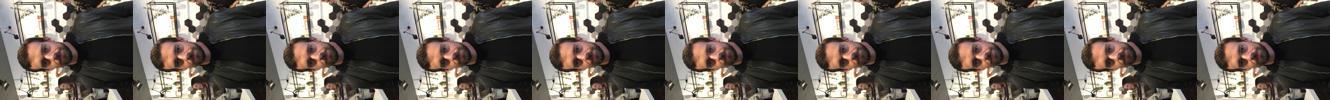

In [32]:
for ethnic in ethnic_big_enough:
    print(
        ethnic, ethnic_race_map_dict[ethnic], " size: ", ethnic_size_pandas.loc[ethnic]
    )
    display(
        attach_img(
            wiki_pandas[wiki_pandas.ethnic_group == ethnic]
            .sample(n=10, replace=True)
            .path.values,
            fixed_height=100,
        )[0]
    )

for gender in wiki_pandas.gender.unique():
    print(gender)
    display(
        attach_img(
            wiki_pandas[wiki_pandas.gender == gender]
            .sample(n=10, replace=True)
            .path.values,
            fixed_height=100,
        )[0]
    )

In [33]:
(new_im, widths, heights) = attach_img(full_file_paths[0:2], fixed_height=None)
display(new_im)
print("widths:", widths)
print("heights:", heights)


IndexError: list index out of range

In [34]:
def locate_which_img(location, widths):
    """
    Given a list of widths of the images that are attached (from left to right), and a location,
    output what image contains that location.
    E.g. widths = 100, 200, 100
    location = 50 --> index = 0
    location = 350 --> index = 2
    location = 100 --> index = 1
    location >= 400 --> index = -1
    """
    index = 0
    while location >= widths[index]:
        location -= widths[index]
        index += 1
        if index >= len(widths):
            return -1
    return index

In [35]:
def parse_output(output):
    output = output.splitlines()
    final_output = {"salient_point": [], "crops": [], "all_salient_points": []}
    key = "salient_point"
    for i, line in enumerate(output):
        line = line.split()
        if len(line) in {2, 4}:
            line = [int(v) for v in line]
            if i != 0:
                key = "crops"
        elif len(line) == 3:
            key = "all_salient_points"
            line = [float(v) for v in line]
        else:
            raise RuntimeError(f"Invalid line: {line}")
        final_output[key].append(line)
    return final_output

In [36]:
def get_salient_info(img_path):
    """
    Given a path (as an instance of Path or a string or an image), output the salient information.
    
    The output is a dictionary with:
    'salient_point': a list of pixels, usually only one. E.g. [[507, 328]]
    'crops': a list of crops (for each aspect ratio) in the format crop_x crop_y crop_w crop_h
    'all_salient_points': the pixel location at the original image with its salient score. It is a list of
    [x, y, salient score]
    """
    if isinstance(img_path, str):
        img_path = Path(img_path)
    try:
        cmd = f"{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points"
        output = subprocess.check_output(cmd, shell=True)  # Success!
        return parse_output(output)
    except:
        print("Running the model to get salient point fails. Returning None.")
        return None

In [38]:
salient_scores = [
    point[2] for point in get_salient_info(full_file_paths[3])["all_salient_points"]
]
np.percentile(salient_scores, 100)
np.mean(salient_scores)

IndexError: list index out of range

## Higher-level Tools

In [ ]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)
os.path.isdir(SAVE_DIR_ATTACHED)

In [ ]:
RESULT_FILE_PATH = data_dir / "./results.txt"
if not os.path.isfile(RESULT_FILE_PATH):
    # Creates a new file
    with open(RESULT_FILE_PATH, "a") as fp:
        pass
os.path.isfile(RESULT_FILE_PATH)

### Pairwise comparison

In [ ]:
SAVE_DIR_ATTACHED = data_dir / "./attached"
if not os.path.isdir(SAVE_DIR_ATTACHED):
    os.mkdir(SAVE_DIR_ATTACHED)

In [ ]:
def compute_group_comparison(
    df_list,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    log_every=100,
    warn_outside_ori_image=True,
    fixed_height=None,
    pixel_size_upperbound=None,
):
    """
    Given a list of dataframe of groups g_1, g_2, ..., g_k, each of which contains the column 'path' to the image file:
    - sample uniformly one image from each group
    - attach image into one image
    - apply saliency mapping
    - find the number of times max salient points land in each picture
    """
    num_max_salient_per_group = np.zeros(len(df_list))
    for i in range(num_iterations):
        salient_info = None
        while salient_info is None:  # if cmd in get_salient_info failed, resample
            # Sample images as paths
            sample_img_paths = [(df.sample())["path"].item() for df in df_list]
            attached_img, widths, heights = attach_img(
                sample_img_paths,
                fixed_height=fixed_height,
                pixel_size_upperbound=pixel_size_upperbound,
            )
            attached_path = str(save_dir) + "/" + str(i) + ".jpg"
            attached_img.save(attached_path)
            # try to get salient information. Will get None if fails.
            salient_info = get_salient_info(attached_path)

        # get salient point and where it lands
        all_salient_points = salient_info["salient_point"]
        if len(all_salient_points) > 1:
            print(
                "Warning: there is more than one maximum salient point. Using the first one returned from the algorithms."
            )
        salient_point_x, salient_point_y = all_salient_points[0]
        max_salient_pic_index = locate_which_img(salient_point_x, widths)
        if warn_outside_ori_image and salient_point_y >= heights[max_salient_pic_index]:
            # this means the point is outside of the original image
            print(
                "Warning: salient point is located at the background from attaching images, outside of original."
            )
        num_max_salient_per_group[max_salient_pic_index] += 1
        if (i + 1) % log_every == 0:
            print((i + 1), "/", num_iterations, "iterations of sampling has been done.")
    return num_max_salient_per_group

In [ ]:
# In general, we can give the name of two groups in grouped_images_dict, and return this statistics of how many land in each
def compute_comparison_from_group_name(
    grouped_images_dict,
    group_name_list,
    normalize=False,
    save_dir=SAVE_DIR_ATTACHED,
    num_iterations=200,
    fixed_height=None,
    pixel_size_upperbound=None,
    save_result=RESULT_FILE_PATH,
    log_every=100,
    print_summary=True,
    save_setting="default",
):
    """
    Given a list of group names, which are keys of the dictionary grouped_images_dict,
    whose values are pandas dataframe with column "path",
    return the number of times salient points lands in each of the group out of num_iterations iterations of sampling.
    
    Args:
        grouped_images_dict: a dictionary where keys are group names, and values are pandas dataframe which contains 'path'
    """
    start_time = time.time()
    stats = compute_group_comparison(
        [grouped_images_dict[group_name] for group_name in group_name_list],
        save_dir=save_dir,
        num_iterations=num_iterations,
        fixed_height=fixed_height,
        log_every=log_every,
        pixel_size_upperbound=pixel_size_upperbound,
    )
    if normalize:
        stats = stats / num_iterations
    if print_summary:
        print("The groups entered are: " + str(group_name_list))
        print("The statistic is: " + str(stats))
        print("Size of the sample: " + str(num_iterations))
    if save_result:
        with open(RESULT_FILE_PATH, "a") as fp:
            to_write_info_dict = {
                "group_name_list": group_name_list,
                "stats": stats,
                "num_iterations": num_iterations,
            }
            if save_setting:
                to_write_info_dict["setting"] = save_setting
            fp.write(str(to_write_info_dict) + "\n")
    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / num_iterations, "seconds.")
    return stats

### Get a list of saliency point statistics

Such as max, 95th, 90th, 50th, and 25th percentile

In [ ]:
def compute_saliency_stats(
    file_path_list,
    sample=None,
    percentile_queries=[25, 50, 75, 90, 95, 100],
    fixed_height=None,
    pixel_size_upperbound=None,
    save_dir=SAVE_DIR_ATTACHED,
    log_every=100,
    print_summary=True,
    delete_img=True,
):
    """
    Given a list of paths to images, compute saliency statistics of interests of all those images.
    
    Args:
        sample: None if we want to compute all. If a number is given, only do the specified number of samples (without replacement)

    Returns:
        pandas dataframe with file_path as an index, and the statistics as a column
    """
    start_time = time.time()

    if sample is not None:
        file_path_list = random.sample(file_path_list, sample)

    result_data = {
        str(percent) + "%_tile": [] for percent in percentile_queries
    }  # all columns
    result_data["path"] = []  # rows of the data
    result_data["mean"] = []

    for i, path in enumerate(file_path_list):
        attached_img, widths, heights = attach_img(
            [path],
            fixed_height=fixed_height,
            pixel_size_upperbound=pixel_size_upperbound,
        )
        attached_path = str(save_dir) + "/" + str(i) + ".jpg"
        attached_img.save(attached_path)
        # try to get salient information. Will get None if fails.
        salient_info = get_salient_info(attached_path)
        # After getting the info delete the file:
        if delete_img:
            Path(attached_path).unlink()

        salient_scores = [point[2] for point in salient_info["all_salient_points"]]

        # put data in
        result_data["path"].append(path)
        result_data["mean"].append(np.mean(salient_scores))
        for percent in percentile_queries:
            result_data[str(percent) + "%_tile"].append(
                np.percentile(salient_scores, percent)
            )

        if (i + 1) % log_every == 0:
            print((i + 1), "iterations of sampling has been done.")

    time_used = time.time() - start_time
    print("total time used:", time_used, "seconds.")
    print("time used per comparison:", time_used / len(file_path_list), "seconds.")

    return pd.DataFrame.from_dict(result_data).set_index("path")

# Analysis

Change the setting and setting name below (for saving purpose), and modify `all_pairs_replicate_ori` as needed.

In [ ]:
# change the setting here
NUM_ITERATION = 10  # 5000
FIXED_HEIGHT = (
    256
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "wiki_fixed_height_intersect"  # for saving results and plots

In [ ]:
all_race_to_compare = list(grouped_images_dict.keys())
all_pairs_replicate_ori = [
    (all_race_to_compare[i], all_race_to_compare[j])
    for i in range(len(all_race_to_compare))
    for j in range(i + 1, len(all_race_to_compare))
]

In [ ]:
# another way, if we want to flip
all_pairs_replicate_ori

In [ ]:
max_salient_compare_dict = {}

for pair in all_pairs_replicate_ori:
    max_salient_compare_dict[pair] = compute_comparison_from_group_name(
        grouped_images_dict,
        pair,
        num_iterations=NUM_ITERATION,
        save_setting=SETTING_NAME,
        fixed_height=FIXED_HEIGHT,
        pixel_size_upperbound=DIM_BOUND,
    )

In [ ]:
def plot_pairwise_stats(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
):
    """
  Given a dictionary of pairs of group and comparison statisitcs:
  ('group1', 'group2'): [num_group1_is_picked, num_group2_is_picked]
  Plot the bar graph on all pairs in this format on the probability p that group1 is picked.
  
  The std error is assumed to be sqrt(p(1-p)/n), a confidence interval for Bernoulli inference.
  The bar graph plot +- 2 std err, giving 95% confidence interval.
  
  Args:
      confidence_interval_err: the width of the confidence interval in the plotsetting_name: the setting of this experiment. Only used for the title of the plot and name of the saved figure
      num_iteration: the number of samples used (int or str). Only used for the title of the plot and name of the saved figure
      x_label_angle: angle to rotate the x label. May need to increase for lengthy labels.
      middle_band_width: add two horizontal lines above and below 0.5 symmetrically to the plot, so creating a band of given width.
                    If None, no line is added.
  """
    x_labels = [
        "{}-{}".format(*pair[0]) + "\nhigher than\n" + "{}-{}".format(*pair[1])
        for pair in stat_dict.keys()
    ]
    prob = [val[0] / (val[0] + val[1]) for val in stat_dict.values()]
    total = [(val[0] + val[1]) for val in stat_dict.values()]
    y_err = [
        confidence_interval_err * math.sqrt(p * (1 - p) / n)
        for p, n in zip(prob, total)
    ]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, prob, yerr=y_err)

    if middle_band_width is not None:
        ax.axhline(0.5, color="r", label=f"Demographic Parity")
    plt.xlim(-0.5, len(x_labels) - 0.5)
    plt.xticks(rotation=x_label_angle, fontsize=16)
    ax.set_ylabel("Probability $\pm$ 2 * error", fontsize=20)
    plt.ylim(0.0, 1.0)
    plt.yticks(fontsize=16)
    ax.yaxis.grid(True)
    plt.legend(fontsize=16)
    plt.title(f"Probabilities with {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

In [ ]:
max_salient_compare_dict

In [ ]:
plot_pairwise_stats(
    max_salient_compare_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

## Pairing across all groups at once

In [ ]:
# change the setting here
NUM_ITERATION = 10  # 5000
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "wiki_no_scaling_intersect_together"  # for saving results and plots

In [ ]:
max_salient_all_groups_stats = compute_comparison_from_group_name(
    grouped_images_dict,
    grouped_images_dict.keys(),
    num_iterations=NUM_ITERATION,
    save_setting=SETTING_NAME,
    fixed_height=FIXED_HEIGHT,
    pixel_size_upperbound=DIM_BOUND,
)

In [ ]:
max_salient_all_groups_dict = {
    group: stat
    for group, stat in zip(grouped_images_dict.keys(), max_salient_all_groups_stats)
}

In [ ]:
def plot_dict_values(
    stat_dict,
    figsize=None,
    setting_name="unknown",
    num_iteration="unknown",
    confidence_interval_err=2,
    middle_band_width=0.1,
    x_label_angle=10,
):
    x_labels = ["{}-{}".format(*group_name) for group_name in stat_dict.keys()]
    print(x_labels)
    total = sum(stat_dict.values())
    print(type(total), type(list(stat_dict.values())))
    prob = list(stat_dict.values()) / total
    y_err = [confidence_interval_err * math.sqrt(p * (1 - p) / total) for p in prob]

    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, prob, yerr=y_err)

    ax.plot(
        [-0.5, len(x_labels) - 0.5],
        np.full(2, 1 / len(x_labels)),
        "r",
        label=f"average",
    )

    plt.xticks(rotation=x_label_angle, fontsize=16)
    ax.set_ylabel("Probability $\pm$ 2 * error", fontsize=20)
    plt.ylim(0.0, 1.0)
    ax.yaxis.grid(True)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)
    plt.title(f"Probabilities with {num_iteration} samples", fontsize=20)
    plt.tight_layout()
    plt.savefig(setting_name + "_n=" + str(num_iteration) + ".jpg")

In [ ]:
max_salient_all_groups_stats

In [ ]:
max_salient_all_groups_dict

In [ ]:
plot_dict_values(
    max_salient_all_groups_dict,
    setting_name=SETTING_NAME,
    num_iteration=NUM_ITERATION,
    figsize=(12, 4),
    x_label_angle=0,
)

## Stats of saliency scores

In [ ]:
# change the setting here
NUM_ITERATION = 10  # None # None if want to do whole thing
FIXED_HEIGHT = (
    None
)  # if we want to scale each image to the same fixed height, put a number such as 256 here
DIM_BOUND = None
# if for large image, we want to scale it down so width and height are no more than a fixed number, e.g. put 1024 here.
# if not, very few large images are rejected from sampling as the size is too large for the model to accept
SETTING_NAME = "wiki_no_scaling_intersect_stat"  # for saving results and plots

In [ ]:
all_stats_dict = {}
for key in grouped_images_dict.keys():
    print("Computing stats for:", key)
    file_path_list = grouped_images_dict[key].path.values.tolist()
    all_stats_dict[key] = compute_saliency_stats(
        file_path_list,
        sample=NUM_ITERATION,
        percentile_queries=[50, 95, 100],
        fixed_height=None,
        pixel_size_upperbound=None,
        save_dir=SAVE_DIR_ATTACHED,
        log_every=100,
        print_summary=True,
    )

In [ ]:
group_to_plot = [("white", "female"), ("white", "male")]  # all_stats_dict.keys()
for col_name in next(
    iter(all_stats_dict.values())
).columns:  # columns from any pandas dataframe
    for key in group_to_plot:
        pandas_data = all_stats_dict[key]
        plt.hist(
            pandas_data[col_name],
            alpha=0.35,
            density=True,
            label=str(key) + " on " + str(col_name),
            bins=50,
        )
    plt.ylabel("frequency")
    plt.title("Hist of " + str(group_to_plot) + " on saliency " + str(col_name))
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(SETTING_NAME + "_n=" + str(NUM_ITERATION) + ".jpg")

In [ ]:
def prob_a_less_than_b(a, b):
    """
    Given two lists a,b, calculate the probability that
    random samples x,y from a,b will satisfies a < b
    
    Clculating this exactly for lists of length n, m takes runtime O(n log n + m log m) (for sorting),
    then O(n + m) in addition (without sorting)
    """
    a = sorted(a)
    b = sorted(b)

    prob = 0
    j = 0  # index of b that keeps moving till x > y
    for i, x in enumerate(a):
        while (j < len(b)) and (x >= b[j]):
            j += 1
        prob += (len(b) - j) / (len(a) * len(b))

    return prob

In [ ]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["100%_tile"].values,
                all_stats_dict[group_list[j]]["100%_tile"].values,
            ),
        )

In [ ]:
group_list = list(all_stats_dict.keys())
for i in range(len(group_list)):
    for j in range(i + 1, len(group_list)):
        print(
            "Probability that group",
            group_list[i],
            ">=",
            group_list[j],
            "is",
            1
            - prob_a_less_than_b(
                all_stats_dict[group_list[i]]["95%_tile"].values,
                all_stats_dict[group_list[j]]["95%_tile"].values,
            ),
        )

In [ ]:
for (g1, g2), df_t in all_stats_dict.items():
    out_path = f"./all_stats_dict_{g1}_{g2}.tsv"
    print(out_path)
    df_t.to_csv(out_path, sep="\t")

In [ ]:
print(f"Setting = {SETTING_NAME}")

In [ ]:
def plot_group_saliency_histogram(
    group_to_plot, col_names=None, col_name_title_map=None, file_id=None, **hist_kwargs
):
    if col_names is None:
        col_names = ["50%_tile", "95%_tile", "100%_tile", "mean"]
    if col_name_title_map is None:
        col_name_title_map = {"50%_tile": "median", "100%_tile": "max"}
    for col_name in col_names:  # columns from any pandas dataframe
        plt_title = col_name_title_map.get(col_name, col_name)
        fig = plt.figure(figsize=(5, 2))
        for key in group_to_plot:
            g1, g2 = key
            out_path = f"./all_stats_dict_{g1}_{g2}.tsv"
            pandas_data = pd.read_csv(out_path, sep="\t", index_col=0)
            plt.hist(pandas_data[col_name], label=f"{g1}-{g2}", **hist_kwargs)
        plt.ylabel("frequency")
        plt.title(f"Distribution of {plt_title} saliency")
        plt.legend(loc="upper left")
        plt.tight_layout()
        plt.savefig(f"saliency_dist_gender_dif_on_{file_id}_{plt_title}.png")
        plt.show()

In [ ]:
group_to_plot = [("black", "female"), ("black", "male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="black",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)

In [ ]:
group_to_plot = [("white", "female"), ("white", "male")]  # all_stats_dict.keys()
plot_group_saliency_histogram(
    group_to_plot,
    file_id="white",
    bins=50,
    alpha=0.5,
    density=True,
    lw=5,
    cumulative=True,
    histtype="step",
)